# Khai báo các thư viện cần dùng

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import random

from collections import Counter

2025-11-15 11:28:28.587869: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763206108.651700     182 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763206108.672046     182 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# Thiết lập cấu hình chung

In [2]:
DATA_DIR = "/kaggle/input/sea-animals-image-dataste"
RANDOM_STATE = 42

# Trực quan hóa dữ liệu

## Kiểm tra nhãn

In [3]:
image_paths = []
labels = []
class_names = []
class_to_paths = {} # Dictionary để lưu đường dẫn ảnh theo từng lớp

for class_name in os.listdir(DATA_DIR):
    class_path = os.path.join(DATA_DIR, class_name)
    if os.path.isdir(class_path):
        class_names.append(class_name)
        class_to_paths[class_name] = []
        for filename in os.listdir(class_path):
            if filename.endswith(('.jpg', '.jpeg', '.png')):
                full_path = os.path.join(class_path, filename)
                image_paths.append(full_path)
                labels.append(class_name)
                class_to_paths[class_name].append(full_path)


## Kiểm tra các nhãn

In [4]:
class_names

['Penguin',
 'Clams',
 'Lobster',
 'Otter',
 'Eel',
 'Corals',
 'Puffers',
 'Squid',
 'Whale',
 'Sea Urchins',
 'Crabs',
 'Starfish',
 'Seal',
 'Octopus',
 'Shrimp',
 'Sharks',
 'Sea Rays',
 'Fish',
 'Seahorse',
 'Nudibranchs',
 'Dolphin',
 'Turtle_Tortoise',
 'Jelly Fish']

## Ánh xạ nhãn sang số

In [5]:
label_to_id = {name: i for i, name in enumerate(class_names)}
y_int = np.array([label_to_id[label] for label in labels])
y_int

array([ 0,  0,  0, ..., 22, 22, 22])

## Trực quan hóa 1 số lớp

In [ ]:
print("--- Mẫu 5 Ảnh Ngẫu nhiên cho Mỗi Lớp ---")
SAMPLE_SIZE = 5
plt.figure(figsize=(15, 4 * len(class_names))) # Chiều cao tùy thuộc số lượng lớp

for i, class_name in enumerate(class_names):
    # Chọn ngẫu nhiên 5 đường dẫn ảnh
    sample_paths = random.sample(class_to_paths[class_name], min(SAMPLE_SIZE, len(class_to_paths[class_name])))
    
    # Tạo subplot cho 5 ảnh mẫu
    for j, path in enumerate(sample_paths):
        plt.subplot(len(class_names), SAMPLE_SIZE, i * SAMPLE_SIZE + j + 1)
        try:
            image = cv2.imread(path)
            # Chuyển từ BGR (OpenCV) sang RGB (Matplotlib)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
            plt.imshow(image)
            plt.title(f"{class_name} ({j+1})", fontsize=10)
            plt.axis('off')
        except Exception as e:
            plt.title(f"Lỗi đọc ảnh: {e}")
            plt.axis('off')

plt.tight_layout()
plt.show()

# Chia dữ liệu

In [7]:
X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths, y_int, test_size=0.3, stratify=y_int, random_state=42
)

y_temp_stratify = [y_int[image_paths.index(p)] for p in X_temp]

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp_stratify, random_state=42
)

print(f"\nSố lượng ảnh Train: {len(X_train)}")
print(f"Số lượng ảnh Validation: {len(X_val)}")
print(f"Số lượng ảnh Test: {len(X_test)}")


Số lượng ảnh Train: 9597
Số lượng ảnh Validation: 2057
Số lượng ảnh Test: 2057


**Chia dữ liệu theo 3 tập: Train / Validation / Test với tỉ lệ lần lượt là: 70% / 15% / 15%. Sử dụng stratify để đảm bảo việc chia ra không bị mất cân bằng lớp ( đảm bảo chia đều )**

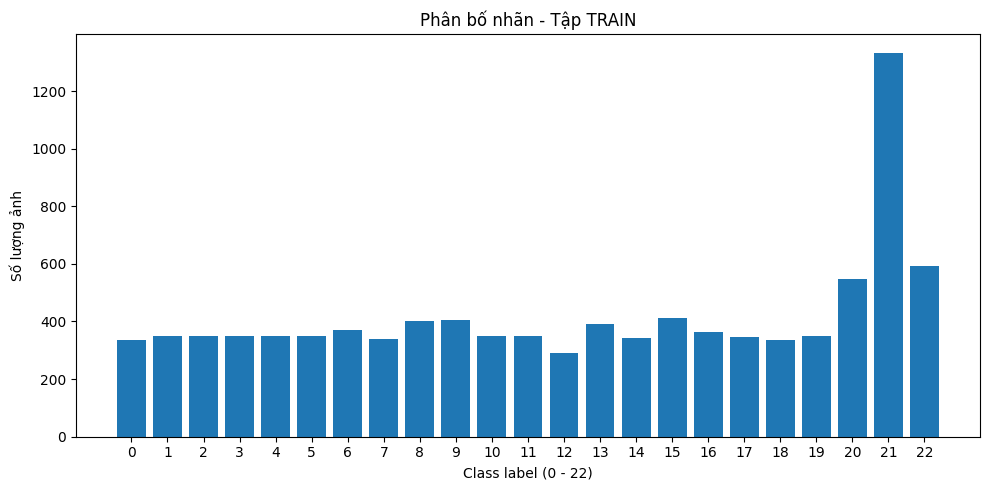

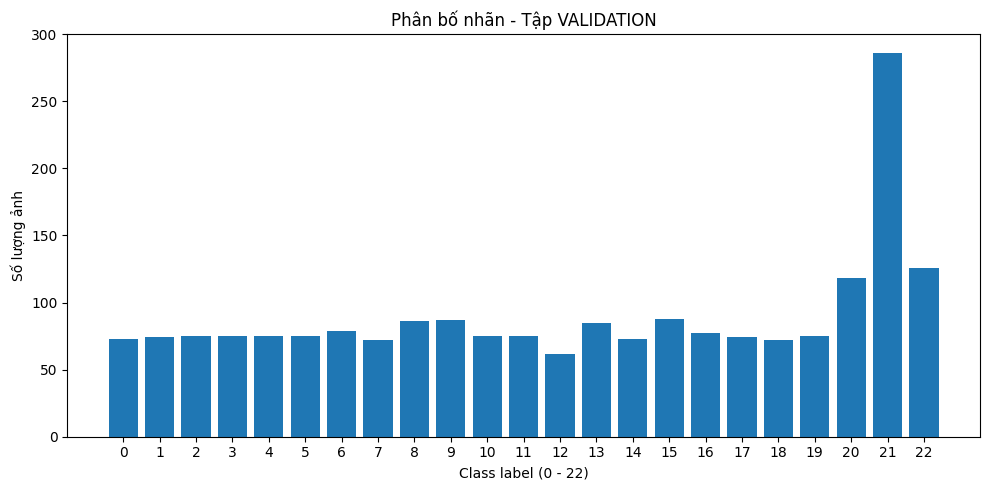

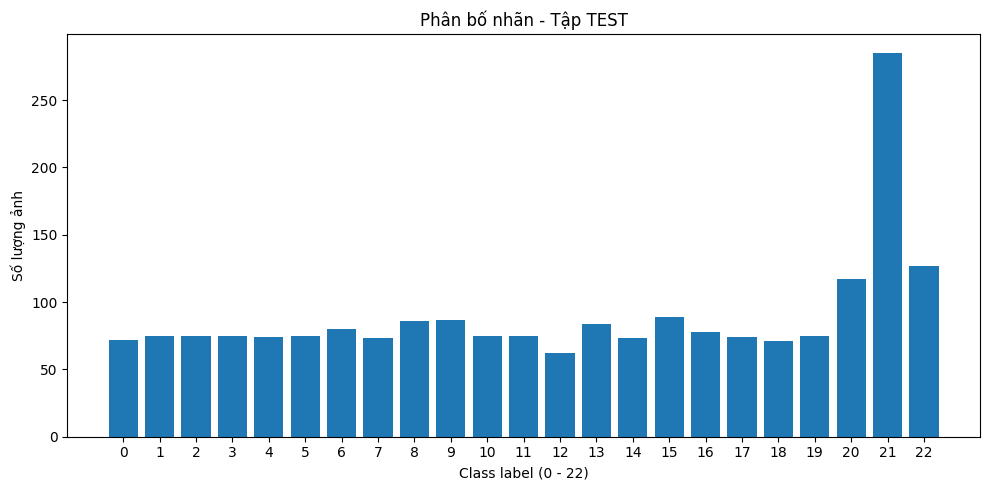

In [8]:
def plot_label_distribution(labels, title):
    counter = Counter(labels)

    classes = list(range(23))   # 0 đến 22
    counts = [counter.get(i, 0) for i in classes]

    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts)
    plt.xticks(classes)
    plt.xlabel("Class label (0 - 22)")
    plt.ylabel("Số lượng ảnh")
    plt.title(title)
    plt.tight_layout()
    plt.show()


plot_label_distribution(y_train, "Phân bố nhãn - Tập TRAIN")
plot_label_distribution(y_val,   "Phân bố nhãn - Tập VALIDATION")
plot_label_distribution(y_test,  "Phân bố nhãn - Tập TEST")

**Nhận xét:** Ta thấy rằng dữ liệu bị mất cân bằng nghiêm trọng, do đó cần phải có biện pháp xử lý. Ở đây ta sẽ dùng phương pháp: Oversampling / Augmentation để tạo thêm dữ liệu mới cho các lớp thiểu số nhằm cân bằng đều lại. Chiến lược này chỉ áp dụng lên trên tập huấn luyện

# Tiền xử lý dữ liệu

In [9]:
RESIZE_DIM = (256, 256) 

def preprocess_image(image_path, dim=RESIZE_DIM):
    """
    Tiền xử lý ảnh theo yêu cầu của Dense SIFT:
    1. Resize
    2. Grayscale
    3. Gaussian Blur (khử nhiễu)
    """
    try:
        image = cv2.imread(image_path)
        if image is None: return None
        
        # 1. Resize
        image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
        
        # 2. Chuyển sang Grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # 3. Khử nhiễu nhẹ bằng Gaussian blur (sigma=0.5)
        gray = cv2.GaussianBlur(gray, (3, 3), 0.5) 
        
        return gray
    except Exception as e:
        # print(f"Lỗi tiền xử lý ảnh {image_path}: {e}")
        return None

In [10]:
def preprocess_dataset(image_paths):
    processed_images = []
    for path in tqdm(image_paths):
        img = preprocess_image(path)
        if img is not None:
            processed_images.append(img)
    return processed_images

In [11]:
X_train = np.array(X_train)
X_val   = np.array(X_val)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [12]:
X_train_processed = preprocess_dataset(X_train)
X_val_processed = preprocess_dataset(X_val)
X_test_processed = preprocess_dataset(X_test)

print(f"Số ảnh Train đã tiền xử lý: {len(X_train_processed)}")
print(f"Số ảnh Val đã tiền xử lý: {len(X_val_processed)}")
print(f"Số ảnh Test đã tiền xử lý: {len(X_test_processed)}")

  0%|          | 0/9597 [00:00<?, ?it/s]

  0%|          | 0/2057 [00:00<?, ?it/s]

  0%|          | 0/2057 [00:00<?, ?it/s]

Số ảnh Train đã tiền xử lý: 9597
Số ảnh Val đã tiền xử lý: 2057
Số ảnh Test đã tiền xử lý: 2057


In [13]:
# 8. Chuẩn bị dữ liệu dạng array để lưu
print("\n💾 Chuẩn bị dữ liệu để lưu...")

# Lưu train, val và test data dưới dạng .npz (compressed)
np.savez_compressed(
    'train_data.npz',
    X=X_train_processed,
    y=y_train
)

np.savez_compressed(
    'val_data.npz',
    X=X_val_processed,
    y=y_val
)

np.savez_compressed(
    'test_data.npz',
    X=X_test_processed,
    y=y_test
)

print("✓ Đã lưu train_data.npz, val_data.npz và test_data.npz")

# Lưu class mapping
import json
with open('class_mapping.json', 'w') as f:
    json.dump(label_to_id, f, indent=2)

print("✓ Đã lưu class_mapping.json")


💾 Chuẩn bị dữ liệu để lưu...
✓ Đã lưu train_data.npz, val_data.npz và test_data.npz
✓ Đã lưu class_mapping.json


## Chiến lược xử lý mất cân bằng dữ liệu trên tập huấn luyện

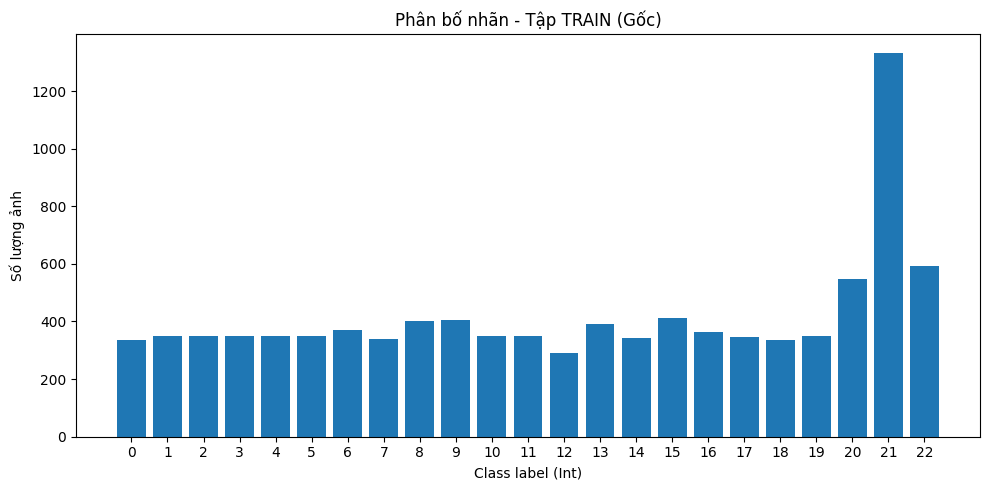

[INFO] Số lượng mẫu tối đa hiện tại: 1332. Mục tiêu Augmentation: 1332 mẫu/lớp.


In [14]:
def plot_label_distribution(labels, title):
    counter = Counter(labels)

    classes = sorted(counter.keys())
    counts = [counter.get(i, 0) for i in classes]

    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts)
    plt.xticks(classes)
    plt.xlabel("Class label (Int)")
    plt.ylabel("Số lượng ảnh")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_label_distribution(y_train, "Phân bố nhãn - Tập TRAIN (Gốc)")

train_counts = Counter(y_train)
max_count = max(train_counts.values())
target_count = int(max_count) 
print(f"[INFO] Số lượng mẫu tối đa hiện tại: {max_count}. Mục tiêu Augmentation: {target_count} mẫu/lớp.")

In [15]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    fill_mode='nearest'
)

Augmenting Classes:   0%|          | 0/23 [00:00<?, ?it/s]


[RESULT] Tổng số mẫu Train sau Augmentation: 30636


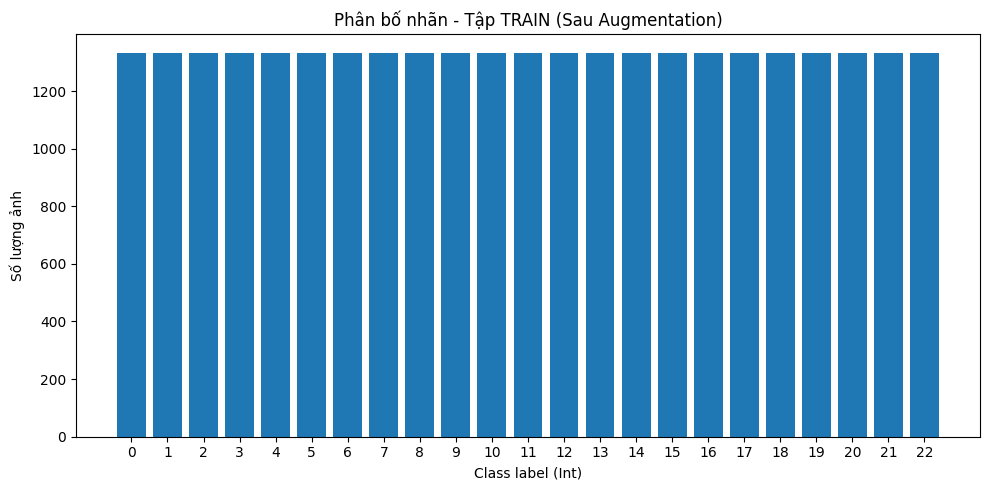

In [16]:
X_train_augmented = []
y_train_augmented = []

all_classes = sorted(train_counts.keys())

for label_id in tqdm(all_classes, desc="Augmenting Classes"):
    current_count = train_counts.get(label_id, 0)
    
    if current_count < target_count:
        minority_paths = X_train[y_train == label_id]
        
        X_minority_raw = []
        for path in minority_paths:
            # Tải lại ảnh GỐC (màu) 
            img = cv2.imread(path)
            if img is not None:
                img = cv2.resize(img, RESIZE_DIM, interpolation=cv2.INTER_AREA)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Chuyển sang RGB
                X_minority_raw.append(img)
        
        X_minority_raw = np.array(X_minority_raw, dtype="float32")
        X_minority_raw = X_minority_raw / 255.0 # Chuẩn hóa 0-1
        
        num_to_generate = target_count - current_count
        
        if len(X_minority_raw) > 0:
            generator = datagen.flow(
                X_minority_raw, 
                np.repeat(label_id, len(X_minority_raw)), 
                batch_size=len(X_minority_raw),
                shuffle=False,
                seed=42
            )
            
            generated_count = 0
            while generated_count < num_to_generate:
                X_batch, _ = next(generator)
                
                for img_batch in X_batch:
                    if generated_count < num_to_generate:
                        # Chuyển ảnh màu RGB (0-1) về grayscale (0-255) và tiền xử lý lại (grayscale, blur)
                        img_255 = (img_batch * 255).astype(np.uint8)
                        
                        gray = cv2.cvtColor(img_255, cv2.COLOR_RGB2GRAY)
                        gray = cv2.GaussianBlur(gray, (3, 3), 0.5) 
                        
                        X_train_augmented.append(gray)
                        y_train_augmented.append(label_id)
                        generated_count += 1
                    else:
                        break

X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)

# Nối tập TRAIN gốc (đã tiền xử lý) và tập AUGMENTED
X_train_final = np.concatenate((np.array(X_train_processed), X_train_augmented), axis=0)
y_train_final = np.concatenate((y_train, y_train_augmented), axis=0)

print(f"\n[RESULT] Tổng số mẫu Train sau Augmentation: {len(X_train_final)}")
plot_label_distribution(y_train_final, "Phân bố nhãn - Tập TRAIN (Sau Augmentation)")

# Trích xuất đặc trưng

## Trích xuất Dense SIFT Descriptors

In [17]:
sift = cv2.SIFT_create()
step_size = 16 # Lưới 16x16 pixels

def get_dense_keypoints(img, step=step_size):
    """Tạo lưới keypoints đồng đều (Dense Keypoints)"""
    keypoints = []
    for x in range(0, img.shape[1], step):
        for y in range(0, img.shape[0], step):
            kp = cv2.KeyPoint(float(x), float(y), size=16)
            keypoints.append(kp)
    return keypoints

def extract_dense_sift(img_list):
    """Trích xuất Dense SIFT descriptors cho toàn bộ tập dữ liệu"""
    all_descriptors = []
    
    for img in tqdm(img_list, desc="Dense SIFT Extraction"):
        if img is None or img.size == 0: 
            all_descriptors.append(None) 
            continue
        
        keypoints = get_dense_keypoints(img)
        _, descriptors = sift.compute(img, keypoints)
        
        all_descriptors.append(descriptors)
            
    return all_descriptors

# Trích xuất Dense SIFT
X_train_desc_list = extract_dense_sift(X_train_final)
X_val_desc_list = extract_dense_sift(X_val_processed)
X_test_desc_list = extract_dense_sift(X_test_processed)

def filter_none(desc_list, y_labels):
    """Lọc bỏ các ảnh không có descriptors (None hoặc rỗng)"""
    # Sử dụng np.array(desc_list) để có thể dùng list comprehension
    filtered_desc_list = [desc for desc in desc_list if desc is not None and desc.shape[0] > 0]
    
    # Lấy chỉ mục của các descriptors hợp lệ
    valid_indices = [i for i, desc in enumerate(desc_list) if desc is not None and desc.shape[0] > 0]
    filtered_y = y_labels[valid_indices]
    
    return filtered_desc_list, filtered_y

# Lọc các mẫu lỗi (nếu có) và cập nhật nhãn
X_train_desc_list, y_train_vlad = filter_none(X_train_desc_list, y_train_final)
X_val_desc_list, y_val_vlad = filter_none(X_val_desc_list, y_val)
X_test_desc_list, y_test_vlad = filter_none(X_test_desc_list, y_test)

# Nối tất cả các descriptors của tập TRAIN thành một mảng lớn cho K-Means
X_train_desc_stacked = np.concatenate(X_train_desc_list, axis=0)

print(f"\n[RESULT] Tổng số Descriptors tập Train: {X_train_desc_stacked.shape}")
print(f"[RESULT] Số lượng mẫu Train sau lọc: {len(y_train_vlad)}")
print(f"[RESULT] Số lượng mẫu Val sau lọc: {len(y_val_vlad)}")
print(f"[RESULT] Số lượng mẫu Test sau lọc: {len(y_test_vlad)}")

Dense SIFT Extraction:   0%|          | 0/30636 [00:00<?, ?it/s]

Dense SIFT Extraction:   0%|          | 0/2057 [00:00<?, ?it/s]

Dense SIFT Extraction:   0%|          | 0/2057 [00:00<?, ?it/s]


[RESULT] Tổng số Descriptors tập Train: (7842816, 128)
[RESULT] Số lượng mẫu Train sau lọc: 30636
[RESULT] Số lượng mẫu Val sau lọc: 2057
[RESULT] Số lượng mẫu Test sau lọc: 2057


## Học Từ điển Thị giác (K-Means cho VLAD)

In [18]:
K = 64 # Kích thước codebook: K=32-64 cho VLAD là tối ưu

print(f"[INFO] Bắt đầu K-Means với K={K} (học từ điển VLAD)...\n")

# Lấy mẫu ngẫu nhiên nếu tập descriptors quá lớn (để tăng tốc)
MAX_DESC_FOR_KMEANS = 100000
if X_train_desc_stacked.shape[0] > MAX_DESC_FOR_KMEANS:
    print(f"[INFO] Chỉ lấy {MAX_DESC_FOR_KMEANS} descriptors ngẫu nhiên để học K-Means.")
    indices = np.random.choice(X_train_desc_stacked.shape[0], MAX_DESC_FOR_KMEANS, replace=False)
    kmeans_data = X_train_desc_stacked[indices]
else:
    kmeans_data = X_train_desc_stacked
    
# n_init=10 để đảm bảo hội tụ tốt
kmeans = KMeans(n_clusters=K, random_state=RANDOM_STATE, n_init=10, verbose=1)
kmeans.fit(kmeans_data)

centers = kmeans.cluster_centers_
print(f"\n[RESULT] Kích thước Codebook: {centers.shape}")

[INFO] Bắt đầu K-Means với K=64 (học từ điển VLAD)...

[INFO] Chỉ lấy 100000 descriptors ngẫu nhiên để học K-Means.
Initialization complete
Iteration 0, inertia 10580787200.0.
Iteration 1, inertia 7715660800.0.
Iteration 2, inertia 7543123456.0.
Iteration 3, inertia 7479020032.0.
Iteration 4, inertia 7443272704.0.
Iteration 5, inertia 7421373952.0.
Iteration 6, inertia 7406993408.0.
Iteration 7, inertia 7396466176.0.
Iteration 8, inertia 7388132352.0.
Iteration 9, inertia 7380897792.0.
Iteration 10, inertia 7374750720.0.
Iteration 11, inertia 7369348096.0.
Iteration 12, inertia 7364910592.0.
Iteration 13, inertia 7361429504.0.
Iteration 14, inertia 7358620672.0.
Iteration 15, inertia 7356304896.0.
Iteration 16, inertia 7354455040.0.
Iteration 17, inertia 7352955904.0.
Iteration 18, inertia 7351633408.0.
Iteration 19, inertia 7350342144.0.
Iteration 20, inertia 7349089280.0.
Iteration 21, inertia 7347842048.0.
Iteration 22, inertia 7346655232.0.
Iteration 23, inertia 7345471488.0.
Itera

## VLAD Encoding và Chuẩn hóa

In [19]:
def vlad_encode(descriptors_list, kmeans_model, codebook_centers):
    """Tính toán VLAD vector cho một tập hợp descriptors"""
    K = kmeans_model.n_clusters
    D = codebook_centers.shape[1] # Kích thước descriptor (128 cho SIFT)
    vlad_vectors = []
    
    for descriptors in tqdm(descriptors_list, desc="VLAD Encoding"):
        
        # 1. Dự đoán cluster cho từng descriptor (Closest Center)
        labels = kmeans_model.predict(descriptors)
        
        # 2. Khởi tạo VLAD vector
        vlad = np.zeros([K, D])
        
        # 3. Tính Residuals (Sự khác biệt) và Aggregate
        for i in range(K):
            cluster_descriptors = descriptors[labels == i]
            if cluster_descriptors.size > 0:
                residual = cluster_descriptors - codebook_centers[i]
                vlad[i] = np.sum(residual, axis=0)
                
        # 4. Flatten và chuẩn hóa (L2 và Power normalization)
        vlad = vlad.flatten()
        
        # Chuẩn hóa L2 (L2-normalization)
        vlad = vlad / (np.linalg.norm(vlad) + 1e-12) 
        
        # Power normalization (squareroot normalization) 
        vlad = np.sign(vlad) * np.sqrt(np.abs(vlad))
        
        # Chuẩn hóa L2 lần nữa (L2-normalization)
        vlad = vlad / (np.linalg.norm(vlad) + 1e-12)
        
        vlad_vectors.append(vlad)
        
    return np.array(vlad_vectors)

# Tính toán VLAD cho các tập dữ liệu
X_train_vlad = vlad_encode(X_train_desc_list, kmeans, centers)
X_val_vlad = vlad_encode(X_val_desc_list, kmeans, centers)
X_test_vlad = vlad_encode(X_test_desc_list, kmeans, centers)

print(f"\n[RESULT] Kích thước đặc trưng VLAD (Train): {X_train_vlad.shape}")
print(f"[RESULT] Kích thước đặc trưng VLAD (Val): {X_val_vlad.shape}")
print(f"[RESULT] Kích thước đặc trưng VLAD (Test): {X_test_vlad.shape}")

VLAD Encoding:   0%|          | 0/30636 [00:00<?, ?it/s]

VLAD Encoding:   0%|          | 0/2057 [00:00<?, ?it/s]

VLAD Encoding:   0%|          | 0/2057 [00:00<?, ?it/s]


[RESULT] Kích thước đặc trưng VLAD (Train): (30636, 8192)
[RESULT] Kích thước đặc trưng VLAD (Val): (2057, 8192)
[RESULT] Kích thước đặc trưng VLAD (Test): (2057, 8192)


#  Huấn luyện và Đánh giá Mô hình

## Chuẩn hóa và Huấn luyện SGD Classifier

In [20]:
# 1. Chuẩn hóa Đặc trưng (Scaling toàn cục)
scaler = StandardScaler()
X_train_vlad_scaled = scaler.fit_transform(X_train_vlad)
X_val_vlad_scaled = scaler.transform(X_val_vlad)
X_test_vlad_scaled = scaler.transform(X_test_vlad)

# 2. Huấn luyện Linear SVM
print("[INFO] Bắt đầu Huấn luyện Linear SVM...")
# Chọn C=1.0 là giá trị mặc định/khởi đầu tốt
sgd_classifier = SGDClassifier(loss='hinge', max_iter=1000, tol=1e-3, random_state=42)

# Sử dụng y_train_vlad (nhãn đã được lọc và augmented)
sgd_classifier.fit(X_train_vlad_scaled, y_train_vlad)

print("[INFO] Hoàn thành Huấn luyện.")

[INFO] Bắt đầu Huấn luyện Linear SVM...
[INFO] Hoàn thành Huấn luyện.


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


## Đánh giá Mô hình

In [ ]:
# 1. Dự đoán trên tập Test
y_pred_test = sgd_classifier.predict(X_test_vlad_scaled)

# 2. Đánh giá kết quả (sử dụng nhãn đã được lọc: y_test_vlad)
print("\n--- Đánh giá trên tập TEST ---")
print(classification_report(y_test_vlad, y_pred_test, target_names=class_names, zero_division=0))

# 3. Trực quan hóa Confusion Matrix
cm = confusion_matrix(y_test_vlad, y_pred_test)
plt.figure(figsize=(14, 12))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Linear SVM (Dense SIFT + VLAD)')
plt.colorbar()

# Thiết lập nhãn trục
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)
plt.xlabel('Nhãn Dự đoán')
plt.ylabel('Nhãn Thực tế')

# Hiển thị các giá trị 
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), 
                 ha="center", va="center", 
                 color="white" if cm[i, j] > thresh else "black", 
                 fontsize=7)

plt.tight_layout()
plt.show()